In [12]:
import os
import glob
import tiktoken
import numpy as np
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from openai import OpenAI

In [13]:
ollama_url = "http://localhost:11434/v1"
ollama = OpenAI(api_key= "ollama",base_url=ollama_url)
MODEL = "llama3.2:1b"

In [14]:
knowledge_base_path = "knowledge-base/**/*.md"
files = glob.glob(knowledge_base_path,recursive=True)
print(f"Found {len(files)} files in the knowledge base")

entire_knowledge_base = ""
for file_path in files:
    with open(file_path, "r",encoding='utf-8') as f:
        entire_knowledge_base += f.read()
        entire_knowledge_base += "\n\n"

print(f"Total characters in knowledge base: {len(entire_knowledge_base):,}")

Found 31 files in the knowledge base
Total characters in knowledge base: 88,151


In [15]:
encoding = tiktoken.encoding_for_model("gpt-4.1-mini")
tokens = encoding.encode(entire_knowledge_base)
token_count = len(tokens)
print(f"Total tokens for {MODEL}: {token_count:,}")

Total tokens for llama3.2:1b: 18,160


In [16]:
folders = glob.glob("knowledge-base/*")

documents = []

for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob ="**/*.md", loader_cls = TextLoader, loader_kwargs={'encoding': 'utf-8'})
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc-type"] = doc_type
        documents.append(doc)
print(f"Loaded {len(documents)} documents") 

Loaded 31 documents


In [17]:
documents[5]

Document(metadata={'source': 'knowledge-base\\contracts\\Contract with BrightWay Solutions for Markellm.md', 'doc-type': 'contracts'}, page_content='# Contract with BrightWay Solutions for Markellm\n\n**Contract Date:** October 5, 2023  \n**Contract ID:** INS-2023-0092\n\n### Terms\nThis contract (“Contract”) is made between Insurellm, a company incorporated in the United States, and BrightWay Solutions, a technology provider specializing in insurance services.\n\n1. **Scope of Services:**  \n   Insurellm shall provide BrightWay Solutions access to the Markellm platform under the agreed pricing structure for a duration of one year from the effective date.\n\n2. **Payment Terms:**  \n   BrightWay Solutions agrees to pay an initial setup fee of $1,000 for integration services, followed by the Basic Listing Fee of $199 per month for featured listing on Markellm. Payment shall be made within 30 days of invoice.\n\n3. **Service Level Agreement (SLA):**  \n   Insurellm commits to a 99.9% upt

In [18]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Divided into {len(chunks)} chunks")
print(f"First chunk:\n\n{chunks[5]}")

Divided into 123 chunks
First chunk:

page_content='2. **Seamless Integrations**: The architecture of Rellm allows for easy integration with existing systems used by the Client, including policy management and claims processing.

3. **Customizable Dashboard**: The dashboard will be tailored to display metrics specific to the Client's operational needs, enhancing productivity and facilitating more efficient data access.

4. **Regulatory Compliance**: The solution will include compliance tracking features to assist the Client in maintaining adherence to relevant regulations.

5. **Dedicated Client Portal**: A portal for the Client will facilitate real-time communication and document sharing, ensuring seamless collaboration throughout the partnership.

## Support

1. **Technical Support**: Provider shall offer dedicated technical support to the Client via phone, email, and a ticketing system during business hours (Monday to Friday, 9 AM to 5 PM EST).' metadata={'source': 'knowledge-base\\

In [19]:
chunks[100]

Document(metadata={'source': 'knowledge-base\\employees\\Samuel Trenton.md', 'doc-type': 'employees'}, page_content='## Compensation History\n- **2023:** Base Salary: $115,000 + Bonus: $15,000  \n  *Annual bonus based on successful project completions and performance metrics.*\n\n- **2022:** Base Salary: $110,000 + Bonus: $10,000  \n  *Slight decrease in bonus due to performance challenges during the year.*\n\n- **2021:** Base Salary: $105,000 + Bonus: $12,000  \n  *Merit-based increase, reflecting consistent contributions to the data science team.*\n\n- **2020:** Base Salary: $100,000 + Bonus: $8,000  \n  *Initial compensation as Senior Data Scientist, with a focus on building rapport with cross-functional teams.*\n\n## Other HR Notes\n- **Professional Development:** Completed several workshops on machine learning and AI applications in insurance. Currently pursuing an online certification in deep learning.\n\n- **Engagement in Company Culture:** Regularly participates in team-buildin

In [22]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
db_name = "chroma_db"

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embeddings,
    persist_directory=db_name
)

print(f"Vectorstore created with {vectorstore._collection.count()} documents")


Vectorstore created with 123 documents


In [24]:
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1,include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 384 dimensions in the vector store


In [30]:
result = collection.get(include=["embeddings","documents","metadatas"])
vectors = np.array(result["embeddings"])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata.get("doc_type", "unknown") for metadata in metadatas]

color_map = {
    "products": "blue",
    "employees": "green",
    "contracts": "red",
    "company": "orange",
    "unknown": "gray", 
}

colors = [color_map[t] for t in doc_types]

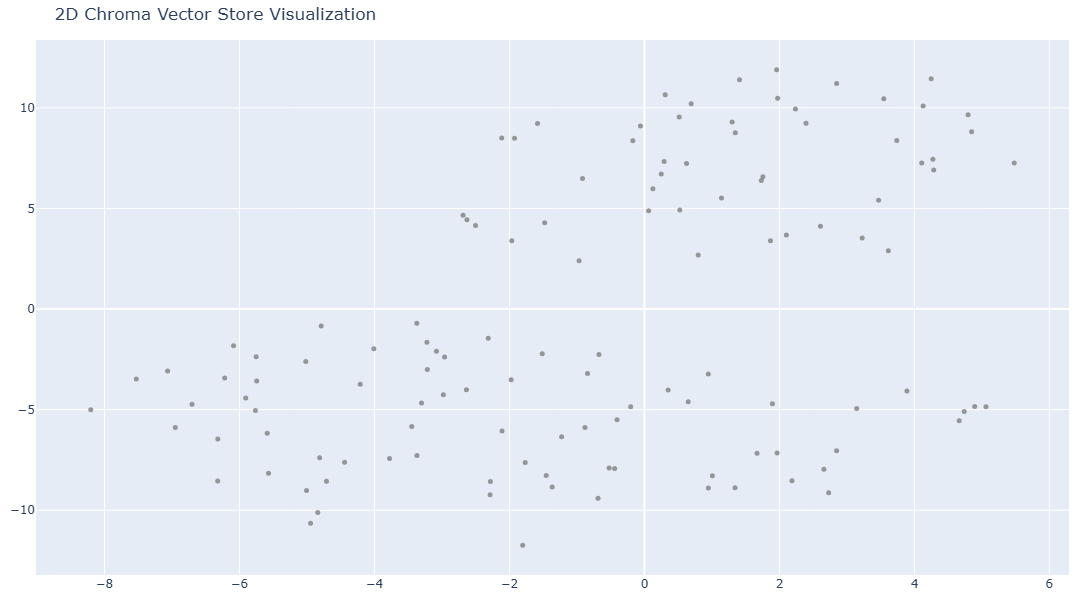

In [31]:
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()